# Import packages

In [2]:
# Continue with regular imports
import os
import numpy as np # linear algebra
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
# try:
from torchinfo import summary

import transformers
import peft

import accelerate
import evaluate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from torch.optim import AdamW
from transformers import get_scheduler, ResNetForImageClassification

from datasets import load_metric

from copy import deepcopy

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
torch.cuda.is_available()

True

# 2. Set up training testing dir

In [5]:
train_dir = "/lora/ISIC2019_train/ImageDR"
test_dir = "/lora/ISIC2019_test"

In [6]:
import yaml

with open("config.yaml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    print(cfg)


{'path': 'lora/ISIC2019_train', 'labels': '/label', 'images': '/original_data', 'use_wandb': False, 'classes': ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'], 'format_file': '.jpg', 'arch': 'ViT', 'checkpoint': 'microsoft/resnet-50', 'dataset': 'ISIC-2019', 'epochs': 100, 'batch_size': 64, 'learning_rate': 0.001}


In [7]:
from datasets import DatasetBuilder
import datasets
import yaml
import os


class ISICDataset(DatasetBuilder):
    
    VERSION = datasets.Version("1.0.0")
    
    def _info(self):
        return datasets.DatasetInfo(
            description="ISIC-2019",
            features=datasets.Features({
                'image': datasets.Value('string'),
                'label': datasets.ClassLabel(names=["AK", "BCC", "BKL", "DF", "MEL", "NV", "SCC", "VASC"]),
            }),
        )

    def _split_generators(self, dl_manager):
        # Point to the directory where your data resides
        extracted_path = os.path.join(dl_manager.manual_dir, "Image_DullRazor")
        return [
            datasets.SplitGenerator(
                name=datasets.Split.TRAIN,
                gen_kwargs={
                    "filepath": extracted_path,
                    "split": "train",
                },
            ),
        ]

    def _generate_examples(self, filepath,split):
        # You can adjust this method based on the exact structure of your data and how you want to read it
        for label in ["AK", "BCC", "BKL", "DF", "MEL", "NV", "SCC", "VASC"]:
            label_path = os.path.join(filepath, label)
            for img_name in os.listdir(label_path):
                yield f"{label}_{img_name}", {
                    "image": os.path.join(label_path, img_name),
                    "label": label,
}

In [8]:
from datasets import DatasetBuilder
import datasets

dataset = datasets.load_dataset("imagefolder",name="ISIC-2019",data_dir=cfg['path']+cfg['images'], split='train')
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

Resolving data files: 100%|████████████| 20264/20264 [00:00<00:00, 64355.48it/s]
Found cached dataset imagefolder (/home/user/.cache/huggingface/datasets/imagefolder/ISIC-2019-60eb30a0cfbe6999/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


In [9]:
label2id, id2label


({'AK': 0,
  'BCC': 1,
  'BKL': 2,
  'DF': 3,
  'MEL': 4,
  'NV': 5,
  'SCC': 6,
  'VASC': 7},
 {0: 'AK',
  1: 'BCC',
  2: 'BKL',
  3: 'DF',
  4: 'MEL',
  5: 'NV',
  6: 'SCC',
  7: 'VASC'})

In [10]:
# function

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    # predictions = np.argmax(eval_pred.predictions, axis=1)
    # return metric.compute(predictions=predictions, references=eval_pred.label_ids)


    pred = eval_pred
    labels = pred.label_ids
    # preds = pred.predictions.argmax(-1)
    preds = np.argmax(eval_pred.predictions, axis=1)
        
    # Calculate 
    

   # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', labels=np.unique(preds))
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [11]:
class CustomCallback(transformers.TrainerCallback):
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
        
    def on_epoch_end(self, args, stage, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

In [13]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

## For ViT or SwinT

In [ ]:
# img_processing = transformers.ViTImageProcessor(do_resize=True,
#                                                do_normalize=True)
image_processor = transformers.AutoImageProcessor.from_pretrained(cfg["checkpoint"])
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(image_processor.size["height"]),
        torchvision.transforms.RandomHorizontalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)
val_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(image_processor.size["height"]),
        torchvision.transforms.CenterCrop(image_processor.size["height"]),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

## For ResNet

In [14]:
image_processor = transformers.AutoImageProcessor.from_pretrained(cfg["checkpoint"])
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(image_processor.size["shortest_edge"]),
        torchvision.transforms.RandomHorizontalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)
val_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(image_processor.size["shortest_edge"]),
        torchvision.transforms.CenterCrop(image_processor.size["shortest_edge"]),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [16]:
# lora alpha should be smaller than lorra rank

model = transformers.AutoModelForImageClassification.from_pretrained(
    cfg["checkpoint"],
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
# Overfitting when r = 10, lora alpha = 16
# slow at 70% even increase to 200 epoch, r = [8,16], alpha = [8,8]
# Slow at 75% r=16, alpha=16, and overfitting at ep 80
# alpha should >= 2*r

# config = peft.LoraConfig(
#     # r=64,
#     # lora_alpha=16,
#     r=4,
#     lora_alpha=32,
#     target_modules=["query", "value"],
    
#     lora_dropout=0.005,
#     bias="none",
#     modules_to_save=["classifier"],
# )

# Target modules
# "List of module names or regex expression of the module names to replace with LoRA."
# "For example, ['q', 'v'] or '.*decoder.*(SelfAttention|EncDecAttention).*(q|v)$'."
# "This can also be a wildcard 'all-linear' which matches all linear/Conv1D layers except the output layer."
# "If not specified, modules will be chosen according to the model architecture, If the architecture is "
# "not known, an error will be raised -- in this case, you should specify the target modules manually."

# lora_model = peft.get_peft_model(model, config)
# print_trainable_parameters(lora_model)

# model = peft.get_peft_model(model)
print_trainable_parameters(model)

model_name = cfg["checkpoint"].split("/")[-1]
args = transformers.TrainingArguments(
    f"{model_name}-finetuned-lora-ISIC-2019",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=cfg["learning_rate"],
    per_device_train_batch_size=cfg["batch_size"],
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=cfg["batch_size"],
    fp16=True,
    num_train_epochs=cfg["epochs"],
    # num_train_epochs=4,
    
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
    optim="adamw_torch"
)


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([8, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 23524424 || all params: 23524424 || trainable%: 100.00


In [14]:
evaluate.list_evaluation_modules()

['lvwerra/test',
 'jordyvl/ece',
 'angelina-wang/directional_bias_amplification',
 'cpllab/syntaxgym',
 'lvwerra/bary_score',
 'hack/test_metric',
 'yzha/ctc_eval',
 'codeparrot/apps_metric',
 'mfumanelli/geometric_mean',
 'daiyizheng/valid',
 'erntkn/dice_coefficient',
 'mgfrantz/roc_auc_macro',
 'Vlasta/pr_auc',
 'gorkaartola/metric_for_tp_fp_samples',
 'idsedykh/metric',
 'idsedykh/codebleu2',
 'idsedykh/codebleu',
 'idsedykh/megaglue',
 'cakiki/ndcg',
 'Vertaix/vendiscore',
 'GMFTBY/dailydialogevaluate',
 'GMFTBY/dailydialog_evaluate',
 'jzm-mailchimp/joshs_second_test_metric',
 'ola13/precision_at_k',
 'yulong-me/yl_metric',
 'abidlabs/mean_iou',
 'abidlabs/mean_iou2',
 'KevinSpaghetti/accuracyk',
 'NimaBoscarino/weat',
 'ronaldahmed/nwentfaithfulness',
 'Viona/infolm',
 'kyokote/my_metric2',
 'kashif/mape',
 'Ochiroo/rouge_mn',
 'giulio98/code_eval_outputs',
 'leslyarun/fbeta_score',
 'giulio98/codebleu',
 'anz2/iliauniiccocrevaluation',
 'zbeloki/m2',
 'xu1998hz/sescore',
 'dvit

In [17]:
# lora_model
model

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [18]:
metric = evaluate.load("accuracy")
trainer = transformers.Trainer(
    # lora_model,
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

trainer.add_callback(CustomCallback(trainer))

train_results = trainer.train()

wandb: Currently logged in as: tridat123123 (tridat). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.962100,0.928395,0.665131,0.649198,0.665131,0.610812
0,0.962100,0.926213,0.670449,0.661638,0.670449,0.614808
1,0.812900,0.780976,0.720787,0.702114,0.720787,0.697629
1,0.812900,0.763296,0.732116,0.709801,0.732116,0.712758
2,0.767200,0.688448,0.754346,0.749873,0.754346,0.741229
2,0.767200,0.709553,0.753823,0.743865,0.753823,0.740572
4,0.708300,0.630396,0.767944,0.770407,0.767944,0.751971
4,0.708300,0.681141,0.757277,0.763884,0.757277,0.745463
4,0.634700,0.542056,0.809508,0.803214,0.809508,0.802295
4,0.634700,0.621284,0.772570,0.759236,0.772570,0.762777


# Save train

In [17]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          99.2
  total_flos               = 88031193536GF
  train_loss               =        0.2388
  train_runtime            =   16:19:51.93
  train_samples_per_second =        27.141
  train_steps_per_second   =         0.105


In [18]:
# trainer.evaluate(val_ds)

metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       99.2
  eval_accuracy           =      0.916
  eval_f1                 =     0.9156
  eval_loss               =     0.4329
  eval_precision          =     0.9157
  eval_recall             =      0.916
  eval_runtime            = 0:00:35.19
  eval_samples_per_second =     50.399
  eval_steps_per_second   =      0.795


In [19]:
trainer.push_to_hub("trantridat/SwinV2Base_lora r64 alpha16 dropout0.05 batchsize64 lr0.001")

'https://huggingface.co/TriDat/swinv2-base-patch4-window12-192-22k-finetuned-lora-ISIC-2019/tree/main/'

In [20]:
trainer.save_model("my_wandb/28042024_Swin/SwinV2Base_lora r64 alpha16 dropout0.05 batchsize64 lr0.001")

In [21]:
lora_model.save_pretrained("my_wandb/28042024_Swin/SwinV2Base_lora r64 alpha16 dropout0.05 batchsize64 lr0.001_weight")

In [22]:
outputs = trainer.predict(val_ds)
print(outputs.metrics)

{'test_loss': 0.4329167902469635, 'test_accuracy': 0.9160090191657272, 'test_precision': 0.9156707582414666, 'test_recall': 0.9160090191657272, 'test_f1': 0.9156304372279399, 'test_runtime': 30.8853, 'test_samples_per_second': 57.438, 'test_steps_per_second': 0.907}


In [17]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

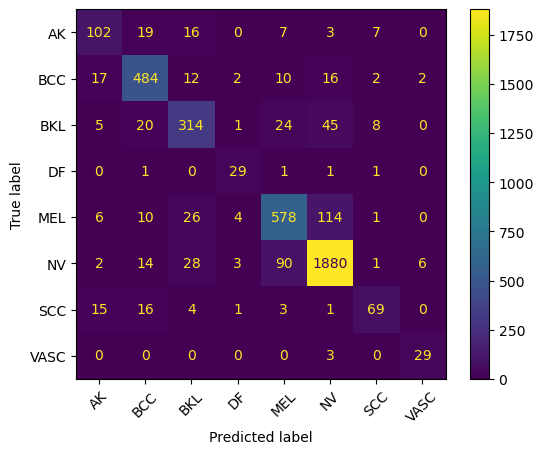

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = val_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)